<a href="https://colab.research.google.com/github/nidhi-059/Region-captioning-on-images-using-dl/blob/main/Task3_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import datasets
import numpy as np


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean for CIFAR-10 RGB channels
                         (0.2023, 0.1994, 0.2010))  # std for CIFAR-10 RGB channels
])

# Download and load the training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load the test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=2)



100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]


In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
epochs = 20
learning_rate = 0.00009

In [ ]:
class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32 → 16

            nn.Conv2d(64, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16 → 8

            nn.Conv2d(192, 384, 3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 8 → 4
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
model1 = AlexNetCIFAR(10)
model1 = model1.to(device)
losses = []
accuracy = []
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate , weight_decay= 1e-4)
for epoch in range(epochs):
    total_labels = 0
    running_acc = 0.0
    running_loss = 0.0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        #forward pass
        y_predic = model1(batch_features)
        #calcuting loss
        loss = loss_func(y_predic , batch_labels)
        #clearing grads
        optimizer.zero_grad()
        #backward pass
        loss.backward()
        #updating parameters
        optimizer.step()
        _, predicted = torch.max(y_predic, dim=1)
        running_acc += (predicted == batch_labels).sum().item()
        total_labels += batch_labels.size(0)
        running_loss += loss.item()

    # Compute epoch accuracy
    avg_loss = running_loss / (len(train_loader))
    avg_acc = running_acc / total_labels
    losses.append(avg_loss)
    accuracy.append(avg_acc)

    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.6f},")


Epoch 1, Loss: 1.267985,
Epoch 2, Loss: 0.861565,
Epoch 3, Loss: 0.707364,
Epoch 4, Loss: 0.616359,
Epoch 5, Loss: 0.539959,
Epoch 6, Loss: 0.472887,
Epoch 7, Loss: 0.418643,
Epoch 8, Loss: 0.365057,
Epoch 9, Loss: 0.328466,
Epoch 10, Loss: 0.286112,
Epoch 11, Loss: 0.255265,
Epoch 12, Loss: 0.224725,
Epoch 13, Loss: 0.204806,
Epoch 14, Loss: 0.176621,
Epoch 15, Loss: 0.162703,
Epoch 16, Loss: 0.149756,
Epoch 17, Loss: 0.135357,
Epoch 18, Loss: 0.120290,
Epoch 19, Loss: 0.117459,
Epoch 20, Loss: 0.106303,


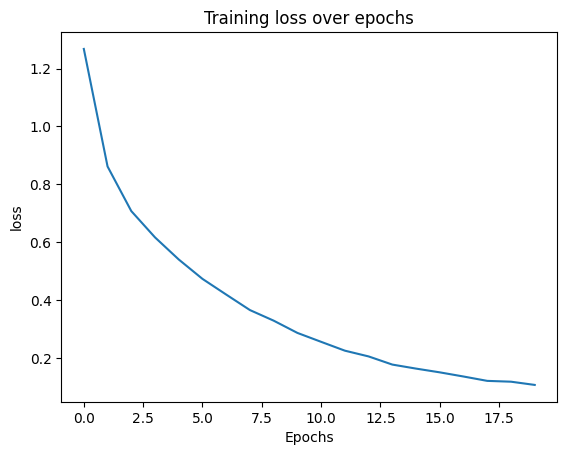

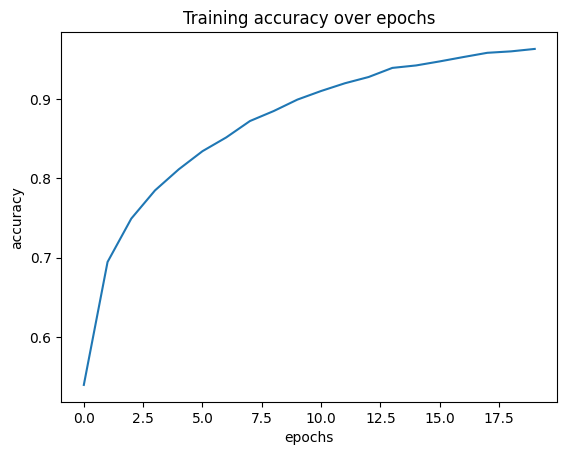

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Training loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.grid(False)
plt.show()
plt.plot(accuracy)
plt.title("Training accuracy over epochs")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid(False)
plt.show()

In [ ]:
#Model evaluation
model1.eval()
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    outputs = model1(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(f"Test accuracy: {(correct/total)*100}%")

Test accuracy: 81.45%


In [ ]:
#Model evaluation

total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    outputs = model1(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(f"Train accuracy : {(correct/total)*100}%")

Train accuracy : 97.198%


In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def unnormalize(img_tensor):
    # Mean and std for CIFAR-10
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2023, 0.1994, 0.2010])
    img_tensor = img_tensor.clone()  # Avoid modifying in-place
    img_tensor *= std[:, None, None]
    img_tensor += mean[:, None, None]
    return img_tensor

def predict(model, image, transform=None, device='cpu'):
    model.to(device)
    model.eval()

    if transform is not None:
        image = transform(image)

    image = image.to(device)
    image_batch = image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image_batch)
        _, predicted = torch.max(outputs, 1)

    predicted_label = classes[predicted.item()]

    # Unnormalize for display
    image_display = unnormalize(image.cpu())
    image_np = np.transpose(image_display.numpy(), (1, 2, 0))

    plt.imshow(image_np)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label


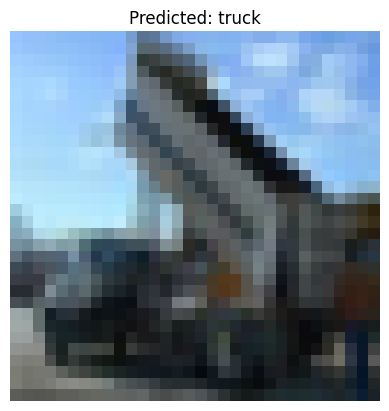

Actual: truck


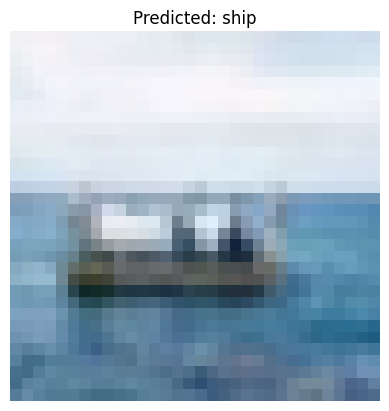

Actual: ship


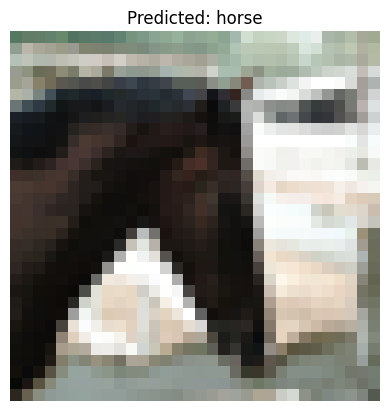

Actual: horse


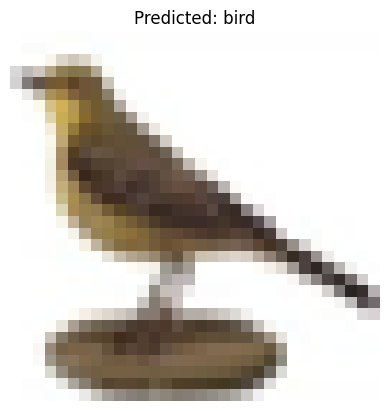

Actual: bird


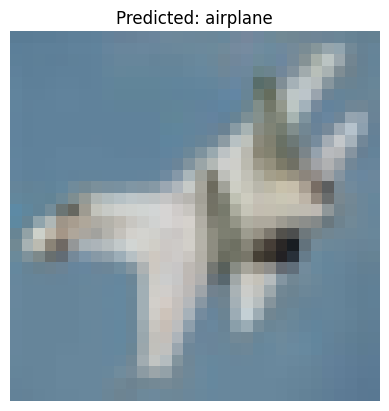

Actual: airplane


In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Just test one image
image = images[50]
label = labels[50]

# Predict
predicted_label = predict(model1, image, transform=None, device=device)
print(f'Actual: {classes[label]}')

image = images[880]
label = labels[880]

# Predict
predicted_label = predict(model1, image, transform=None, device=device)
print(f'Actual: {classes[label]}')

image = images[9990]
label = labels[9990]

# Predict
predicted_label = predict(model1, image, transform=None, device=device)
print(f'Actual: {classes[label]}')

image = images[1110]
label = labels[1110]

# Predict
predicted_label = predict(model1, image, transform=None, device=device)
print(f'Actual: {classes[label]}')

image = images[10]
label = labels[10]

# Predict
predicted_label = predict(model1, image, transform=None, device=device)
print(f'Actual: {classes[label]}')